In [1]:
from tqdm.auto import tqdm 
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf
from netCDF4 import Dataset
%matplotlib inline
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import ast,gc,pickle
from copy import deepcopy
from aquarel import load_theme
import matplotlib.font_manager

# Custom packages
import read_config
from util.data_process import read_vars, proc_dataset, miss
from util.models import performance_scores,train_baseline,causal_settings,train_PC1

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/ships/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read configuration file
config_set = read_config.read_config()
# Define Target
if int(config_set['target_lag'])==4:
    target='DELV24'
elif int(config_set['target_lag'])==8:
    target='DELV48'
seeds = np.arange(100,130,1)

In [ ]:
target='VMAX'
for seed in seeds:
    #---------------------------------------------------------------------------------------------------------
    # Create Pandas DataFrame
    #---------------------------------------------------------------------------------------------------------
    # Process the filted TC list in the config file
    TC_tofilt_list = ast.literal_eval(config_set['TCfilt'])
    # Get the names of the remaining TCs
    filt_TClist = read_vars.remove_storms(trackpath=config_set['track_path'],
                                          basinID=config_set['basin'],
                                          yearmin=int(config_set['start_year']),
                                          yearmax=int(config_set['end_year']),
                                          remove_set=TC_tofilt_list
                                         )
    # Read saved SHIPS csvs
    storeSHIPS = read_vars.read_SHIPS_csv(startyear=int(config_set['start_year']),
                                          endyear=int(config_set['end_year']),
                                          vars_path=config_set['vars_path'],
                                          filted_TCnames=filt_TClist,suffixlist=['newships_dev_POT']
                                         )
    # Read selected variables from the pandas dfs
    SHIPS_df = read_vars.create_SHIPS_df(startyear=int(config_set['start_year']),
                                         endyear=int(config_set['end_year']),
                                         SHIPSdict=storeSHIPS,
                                         wantvarnames=config_set['SHIPSops_varname'],
                                         targetname=target,
                                         filted_TCnames=filt_TClist,
                                         lagnum=int(config_set['target_lag']),
                                         withshift='No',
                                        )
    # Add derived variables stored separately
    store_dfstorms_ships = read_vars.add_derive_df(startyear=int(config_set['start_year']),
                                                   endyear=int(config_set['end_year']),
                                                   SHIPSdict=SHIPS_df,
                                                   addfilepath='/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/SHIPS/ships_pkl/all_storms_ships23vars_obswmax.pkl',
                                                   addvarname=['pc20'],
                                                   filted_TCnames=filt_TClist,
                                                   lagnum=int(config_set['target_lag']),
                                                   withshift='No',
                                                  )
    
    var_names=store_dfstorms_ships[2001]['ALLISON'].columns.values.tolist()
    
    TC_fulllist = {}
    for year in np.linspace(int(config_set['start_year']),int(config_set['end_year']),int(config_set['end_year'])-int(config_set['start_year'])+1):
        temp = store_dfstorms_ships[year]
        for ind,name in enumerate(temp.keys()):
            TC_fulllist[str(int(year))+'_'+name] = temp[name]
            
    #---------------------------------------------------------------------------------------------------------
    # ML-ready dataset
    #---------------------------------------------------------------------------------------------------------
    # Split data with a 0.15 test, 0.15 valid split
    datastorer = proc_dataset.splitdata_handler(df=TC_fulllist,
                                                method='year',
                                                seed=seed,
                                                config=config_set,
                                                testyears=[2020,2021]
                                               )
    # Remove empty storms in the data
    traincleaned = {key: datastorer['train'][key] for ind,key in enumerate(datastorer['train'].keys()) if datastorer['train'][key].shape[0]>0}
    validcleaned = {key: datastorer['valid'][key] for ind,key in enumerate(datastorer['valid'].keys()) if datastorer['valid'][key].shape[0]>0}
    testcleaned = {key: datastorer['test'][key] for ind,key in enumerate(datastorer['test'].keys()) if datastorer['test'][key].shape[0]>0}
    
    # Replace original training data with the cleaned version
    datastorer_n = deepcopy(datastorer)
    
    # Replace
    datastorer_n['train'] = traincleaned
    datastorer_n['valid'] = validcleaned
    datastorer_n['test'] = testcleaned

    # Get smoothed MSLP data and argmin values
    smoothed_MSLP, MSLP_argmin = proc_dataset.proc_data(df=datastorer_n,
                                                    seed=seed).smooth_and_minindices(varname='MSLP',sigma=3)
    # Aligned the inputs with the minimum SLP data
    aligned_train = proc_dataset.proc_data(df=datastorer_n,seed=seed).do_data_align(datastorer_n['train'],MSLP_argmin['train'],var_names)
    aligned_valid = proc_dataset.proc_data(df=datastorer_n,seed=seed).do_data_align(datastorer_n['valid'],MSLP_argmin['valid'],var_names)
    aligned_test = proc_dataset.proc_data(df=datastorer_n,seed=seed).do_data_align(datastorer_n['test'],MSLP_argmin['test'],var_names)
    # Combine different TCs into a long dataset
    X,y,size = proc_dataset.df_proc_separate(aligned_train,aligned_valid,aligned_test,target)
        
    # Find the mean and std of the training set for normalization
    trainmean,trainstd = X['train'].dropna().mean(axis=0),X['train'].dropna().std(axis=0)

    # Data normalization
    Xnorml = proc_dataset.normalized_TCs_handler(train=aligned_train,
                                                 valid=aligned_valid,
                                                 test=aligned_test,
                                                 trainmean=trainmean,
                                                 trainstd=trainstd,
                                                 dropcol=[target],
                                                 target=target
                                                )
    var_names = Xnorml['train'][list(Xnorml['train'].keys())[0]].columns

    #---------------------------------------------------------------------------------------------------------
    # Causal
    #---------------------------------------------------------------------------------------------------------
    onlyships_lag = causal_settings.link_onlyships(numvar=aligned_train[list(aligned_train.keys())[0]].shape[1],
                                                   lag=int(config_set['target_lag']),
                                                   target_ind=[0]
                                                  )

    results = []
    for pc_alpha in tqdm([0.0001, 0.00015 ,0.001,0.0015,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,
                          0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.86,0.88,0.9]):
        Xnorml_c = {'train': {ind: np.asarray(Xnorml['train'][key].replace(np.nan,-999.0)) for ind,key in enumerate(Xnorml['train'].keys())},
                    'valid': {ind: np.asarray(Xnorml['valid'][key].replace(np.nan,-999.0)) for ind,key in enumerate(Xnorml['valid'].keys())},
                    'test': {ind: np.asarray(Xnorml['test'][key].replace(np.nan,-999.0)) for ind,key in enumerate(Xnorml['test'].keys())}
                   }
        result = train_PC1.Pipeline(Xnorml_c['train'],
                                    pc_alpha,
                                    pc_type='run_pcstable',
                                    tau_min0=int(config_set['tau_min']),
                                    tau_max0=int(config_set['tau_max']),
                                    var_name=var_names,
                                    link_assumptions=onlyships_lag).run_tigramite()
        del Xnorml_c
        gc.collect()
        results.append(result)
    
    savetos = {'dataframes':Xnorml,'PC1_results':results,'var_names':var_names}
    with open('../2024_causalML_results/results/'+str(int(config_set['target_lag']))+'_tmin0/'+\
              'SHIPSonly_causal_VMAX/'+'results_seed'+str(int(seed))+'.pkl','wb') as handler:
        pickle.dump(savetos,handler)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 551.37it/s]
22it [00:00, 38.61it/s]
22it [00:00, 116.50it/s]
22it [00:00, 145.95it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 595.69it/s]
22it [00:00, 41.73it/s]
22it [00:00, 119.50it/s]
22it [00:00, 152.28it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 591.69it/s]
22it [00:00, 41.91it/s]
22it [00:00, 117.68it/s]
22it [00:00, 151.58it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 585.98it/s]
22it [00:00, 41.81it/s]
22it [00:00, 118.14it/s]
22it [00:00, 151.19it/s]
100%|███████████████████

In [23]:
aligned_train

{'2000_FLORENCE':     VMAX  VMAX   MSLP   T200   T250    LAT   CSST   PSLV  Z850  D200  ...  \
 0    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN  ...   
 1    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN  ...   
 2    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN  ...   
 3    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN  ...   
 4    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN  ...   
 ..   ...   ...    ...    ...    ...    ...    ...    ...   ...   ...  ...   
 63  60.0  60.0  997.0 -543.0 -422.0  301.0  278.0  562.0  40.0  49.0  ...   
 64  65.0  65.0  994.0 -545.0 -423.0  308.0  279.0  454.0  48.0  42.0  ...   
 65  65.0  65.0  988.0 -545.0 -426.0  326.0  272.0  651.0  61.0  57.0  ...   
 66  65.0  65.0  987.0 -547.0 -429.0  343.0  267.0  729.0  43.0  59.0  ...   
 67  70.0  70.0  985.0 -542.0 -422.0  361.0  263.0  684.0  21.0  86.0  ...   
 
     G200  TADV   SHGC       POT       POT2  

# Performance Skill

In [3]:
var_names = performance_scores.scores_seeds(seed=100,target=target,lag=int(config_set['target_lag'])).read_stored()['var_names']

## No Feature Selection

In [4]:
score_nocausal = []
for seed in tqdm(seeds):
    nocausal_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag'])).run_score_noFS()
    score_nocausal.append(nocausal_results)
    del nocausal_results
    gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.56it/s]


In [5]:
r2_train_noFS = [score_nocausal[i]['scoreboard']['train']['r2'] for i in range(len(score_nocausal))]
r2_valid_noFS = [score_nocausal[i]['scoreboard']['valid']['r2'] for i in range(len(score_nocausal))]
r2_test_noFS = [score_nocausal[i]['scoreboard']['test']['r2'] for i in range(len(score_nocausal))]

## With causally-informed feature selection

In [6]:
score_causal = []
for seed in tqdm(seeds):
    causal_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag'])).run_score_causalFS()
    score_causal.append(causal_results)
    del causal_results
    gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:34<00:00,  7.15s/it]


In [7]:
r2_train_causalFS, r2_valid_causalFS, r2_test_causalFS = [],[],[]
for i in range(len(score_causal)):
    r2_train_causalFS.append([(score_causal[i][j]['scoreboard']['train']['r2']) for j in range(len(score_causal[i]))])
    r2_valid_causalFS.append([(score_causal[i][j]['scoreboard']['valid']['r2']) for j in range(len(score_causal[i]))])
    r2_test_causalFS.append([(score_causal[i][j]['scoreboard']['test']['r2']) for j in range(len(score_causal[i]))])

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

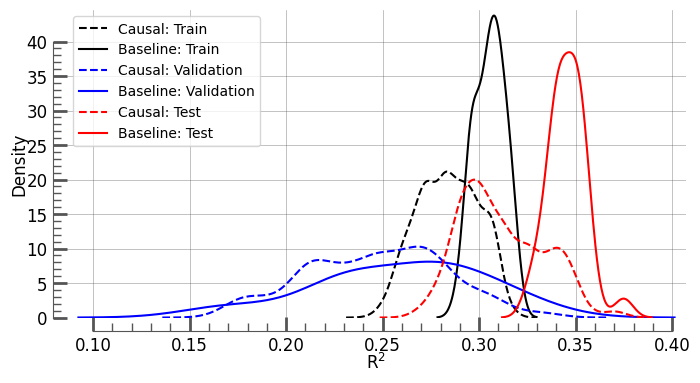

In [10]:
with load_theme("scientific"):
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    sns.kdeplot(np.asarray(miss.flatten(r2_train_causalFS)),ls='--',c='k',label='Causal: Train',ax=ax)
    sns.kdeplot((r2_train_noFS),c='k',ls='-',label='Baseline: Train',ax=ax)
    sns.kdeplot(np.asarray(miss.flatten(r2_valid_causalFS)),ls='--',c='b',label='Causal: Validation',ax=ax)
    sns.kdeplot((r2_valid_noFS),c='b',ls='-',label='Baseline: Validation',ax=ax)
    sns.kdeplot(np.asarray(miss.flatten(r2_test_causalFS)),ls='--',c='r',label='Causal: Test',ax=ax)
    sns.kdeplot((r2_test_noFS),c='r',ls='-',label='Baseline: Test',ax=ax)
    plt.legend(loc=2)
    plt.xlabel('R$^2$')
plt.savefig('./figures/SHIPSonly_r2.png',dpi=600)
plt.show()

## With correlation feature selection

In [22]:
score_correlation = []
for seed in tqdm(seeds):
    correlation_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag'])).run_score_corrFS()
    score_correlation.append(correlation_results)
    del correlation_results
    gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:12<00:00,  4.41s/it]


In [3]:
r2_train_corrFS, r2_valid_corrFS, r2_test_corrFS = [],[],[]
for i in range(len(score_correlation)):
    tempscore = score_correlation[i]['scoreboard']
    trains,valids,tests,shapes=[],[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2'])
        valids.append(tempscore[j]['valid']['r2'])
        tests.append(tempscore[j]['test']['r2'])
    r2_train_corrFS.append(trains)
    r2_valid_corrFS.append(valids)
    r2_test_corrFS.append(tests)

NameError: name 'score_correlation' is not defined

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

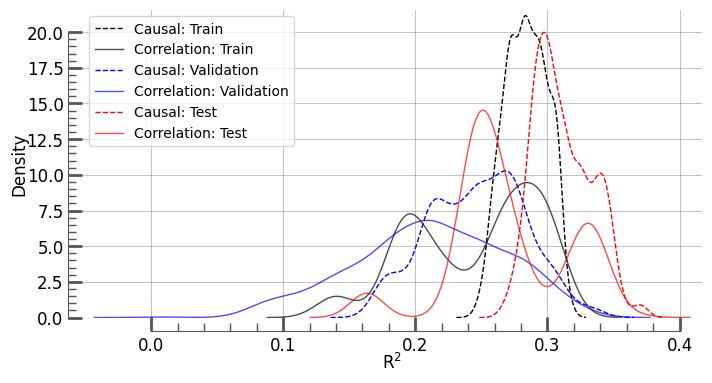

In [37]:
with load_theme("scientific"):
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    sns.kdeplot(np.asarray(miss.flatten(r2_train_causalFS)),ls='--',lw=1,c='k',label='Causal: Train',ax=ax)
    sns.kdeplot(np.asarray(miss.flatten(r2_train_corrFS)),c='k',ls='-',lw=1,alpha=0.7,label='Correlation: Train',ax=ax)
    sns.kdeplot(np.asarray(miss.flatten(r2_valid_causalFS)),ls='--',lw=1,c='b',label='Causal: Validation',ax=ax)
    sns.kdeplot(np.asarray(miss.flatten(r2_valid_corrFS)),c='b',ls='-',lw=1,alpha=0.7,label='Correlation: Validation',ax=ax)
    sns.kdeplot(np.asarray(miss.flatten(r2_test_causalFS)),ls='--',lw=1,c='r',label='Causal: Test',ax=ax)
    sns.kdeplot(np.asarray(miss.flatten(r2_test_corrFS)),c='r',ls='-',lw=1,alpha=0.7,label='Correlation: Test',ax=ax)
    plt.legend(loc=2)
    plt.xlabel('R$^2$')
plt.savefig('./figures/SHIPSonly_r2_corr.png',dpi=600)
plt.show()

## With XAI feature selection

In [20]:
score_corr = []
for seed in tqdm(seeds):
    corr_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag'])).run_score_XAIFS()
    score_corr.append(corr_results)
    del corr_results
    gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [11:46<00:00, 23.56s/it]


In [24]:
r2_train_XAIFS, r2_valid_XAIFS, r2_test_XAIFS = [],[],[]
for i in range(len(score_corr)):
    tempscore = score_corr[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2'])
        valids.append(tempscore[j]['valid']['r2'])
        tests.append(tempscore[j]['test']['r2'])
    r2_train_XAIFS.append(trains)
    r2_valid_XAIFS.append(valids)
    r2_test_XAIFS.append(tests)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

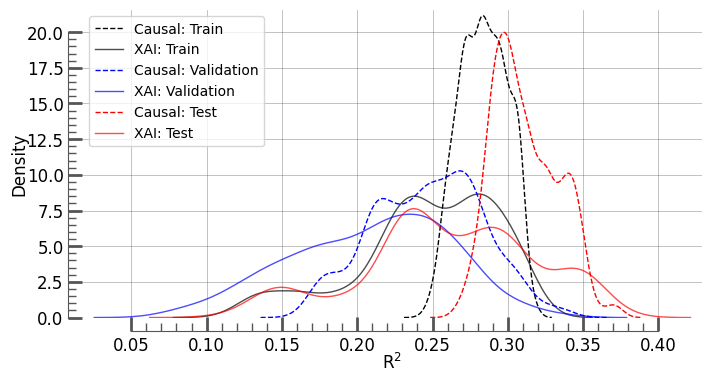

In [29]:
with load_theme("scientific"):
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    sns.kdeplot(np.asarray(miss.flatten(r2_train_causalFS)),ls='--',lw=1,c='k',label='Causal: Train',ax=ax)
    sns.kdeplot(np.asarray(miss.flatten(r2_train_XAIFS)),c='k',ls='-',lw=1,alpha=0.7,label='XAI: Train',ax=ax)
    sns.kdeplot(np.asarray(miss.flatten(r2_valid_causalFS)),ls='--',lw=1,c='b',label='Causal: Validation',ax=ax)
    sns.kdeplot(np.asarray(miss.flatten(r2_valid_XAIFS)),c='b',ls='-',lw=1,alpha=0.7,label='XAI: Validation',ax=ax)
    sns.kdeplot(np.asarray(miss.flatten(r2_test_causalFS)),ls='--',lw=1,c='r',label='Causal: Test',ax=ax)
    sns.kdeplot(np.asarray(miss.flatten(r2_test_XAIFS)),c='r',ls='-',lw=1,alpha=0.7,label='XAI: Test',ax=ax)
    plt.legend(loc=2)
    plt.xlabel('R$^2$')
plt.savefig('./figures/SHIPSonly_r2_XAI.png',dpi=600)
plt.show()

In [26]:
np.asarray(miss.flatten(r2_valid_causalFS)).max()

0.33829931333051033

In [27]:
np.asarray(miss.flatten(r2_valid_XAIFS)).max()

0.33510852393764623

In [28]:
np.asarray(miss.flatten(r2_valid_corrFS)).max()

0.33086011944103166